In [1]:
import csv
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pandas as pd

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({"font.size": 10})
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = True

# plt.rcParams["axes.facecolor"] = "#f5f5f5"
plt.rcParams["grid.color"] = "white"
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.linewidth"] = 2

In [2]:
with open("../data/slippage/eth_usdc_0_05.csv","r") as infile: eth_usdc_0_05_data = pd.read_csv(infile)
with open("../data/slippage/eth_usdc_0_3.csv","r") as infile: eth_usdc_0_3_data = pd.read_csv(infile)
with open("../data/slippage/usdct_usdt_0_01.csv","r") as infile: usdct_usdt_0_01_data = pd.read_csv(infile)
with open("../data/slippage/dai_usdc_0_01.csv","r") as infile: dai_usdc_0_01_data = pd.read_csv(infile)

In [27]:
def get_coinbase_prices(uni_df,vol_window=30):
    with open("../data/ETH-USD_price_3600_1641013200_to_1698854400.csv","r") as infile:
        eth_usdc_price_data = pd.read_csv(infile)
        eth_usdc_price_data.sort_values(by="unix_timestamp", axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
        eth_usdc_price_data['date'] = pd.to_datetime(eth_usdc_price_data['unix_timestamp'], unit='s').dt.date
        daily_eth_usdc_price_data = eth_usdc_price_data.groupby(["date"]).agg({"unix_timestamp":["first","last"],"close":["mean","std"]})
        daily_eth_usdc_price_data_reset = daily_eth_usdc_price_data.reset_index()
        daily_eth_usdc_price_data_reset.columns = ['_'.join(col).rstrip('_') for col in daily_eth_usdc_price_data_reset.columns.values]
        daily_eth_usdc_price_data_reset = daily_eth_usdc_price_data_reset.rename(columns={"close_std": "volatility","close_mean":"mean_price"})    
        daily_eth_usdc_price_data_reset["volatility"] = (daily_eth_usdc_price_data_reset["volatility"]/daily_eth_usdc_price_data_reset["mean_price"])*((365 ** 0.5))
        daily_eth_usdc_price_data_reset['rolling_volatility'] = daily_eth_usdc_price_data_reset['volatility'].rolling(window=vol_window).mean()*((365 ** 0.5))
        daily_eth_usdc_price_data_reset.dropna(inplace=True)

    cb_uni_merge = pd.merge_asof(uni_df, daily_eth_usdc_price_data_reset, left_on='unix_timestamp', right_on='unix_timestamp_first',direction='backward')
    cb_uni_merge.rename(columns={"date_x": "date","rolling_volatility_x":"rolling_volatility","trade_size":"trade_size"},inplace=True)
    return(cb_uni_merge)

# token0 is usdc, token1 is eth
def process_trades(df,name,vol_window=30,type="collateral"):
    df = df[df["amount1_adjusted"]>0].copy() # Sell ETH

    df.rename(columns={"amoun0_adjusted":"amount0_adjusted"},inplace=True)
    df.rename(columns={"amoun1_adjusted":"amount1_adjusted"},inplace=True)
    
    if type=="collateral":
        df["trade_size_x"]=df["amount1_adjusted"].apply(lambda x: (x/1.0e12))
        df["trade_size_y"]=df["amount0_adjusted"].apply(lambda x: (x*1.0e12))
    else:
        df["trade_size_x"]=df["amount1_adjusted"].apply(lambda x: (x))
        df["trade_size_y"]=df["amount0_adjusted"].apply(lambda x: (x))
    
    df["price_implied"] = 1e24/df["price_implied"]
    df["price_actual"] = 1e24/df["price_actual"]
    df["previous_price_actual"] = 1e24/df["previous_price_actual"]
    df["price_impact"]=abs(df["price_implied"]-df["previous_price_actual"])/(df["previous_price_actual"])
    df["evt_block_time"] = pd.to_datetime(df['evt_block_time'], utc=True)
    df['unix_timestamp'] = df['evt_block_time'].astype(int) // 10**9
    df.sort_values(by="unix_timestamp", axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
    df['date'] = pd.to_datetime(df['unix_timestamp'], unit='s').dt.date
    merged_df = get_coinbase_prices(df,vol_window=vol_window).dropna()
    merged_df["new_cross_impact"]=merged_df["rolling_volatility"]*merged_df["trade_size_x"]
    return(merged_df)    

def plot_stats(merged_df,name,type="collateral"):
    print(merged_df.columns,merged_df.shape)

    plt.figure()
    # plt.plot(merged_df["date"],merged_df["std_price"]/merged_df["price_actual_mean"], label='std_price')
    plt.plot(merged_df["date"],merged_df["rolling_volatility"],label='rolling_volatility')
    plt.scatter(merged_df["date"],merged_df["price_impact"],label='price_impact',alpha=0.1,c=merged_df["trade_size_x"],cmap='viridis')
    plt.legend()
    plt.title(name)
    cbar = plt.colorbar()
    cbar.set_label('Trade Size')
    plt.show()

    ##############################################
    print(merged_df[["price_impact", "trade_size_x"]])
    plt.figure()
    plt.plot(merged_df["date"], merged_df["rolling_volatility"], label='rolling_volatility')
    ax2 = plt.twinx()
    scatter = ax2.scatter(merged_df["date"], 100 * merged_df["price_impact"] / merged_df["trade_size_x"], label='price_impact/trade_size', alpha=0.1, c=merged_df["rolling_volatility"], cmap='viridis')
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Rolling Volatility')
    plt.title(name)
    handles1, labels1 = plt.gca().get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2
    plt.legend()
    plt.show()


    plt.figure()
    plt.scatter(merged_df["trade_size_x"],merged_df["price_impact"],c=merged_df["rolling_volatility"],cmap='viridis')
    plt.title(name)
    plt.show()

    plt.figure()
    plt.plot(merged_df["unix_timestamp"],merged_df["price_actual"])    
    plt.title(name)
    plt.show()
    return(merged_df)

def gen_multi_var_reg(df, x_vars, y_var, v=False):    
    X = sm.add_constant(df[x_vars])
    y = df[y_var]

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Get the summary
    if v:
        print(model.summary())

    return model

def lin_reg(df, x_var="trade_size_x", y_var="price_impact",name=None,color_var="rolling_volatility"):
    print("lin_reg")
    # Linear regression
    # Generate Y-values based on the regression model
    p, cov = np.polyfit(df[x_var], df[y_var], 1, cov=True)  # Assuming x and y are your data arrays
    slope = p[0]
    intercept = p[1]
    errors = np.sqrt(np.diag(cov))
    y_fit = slope * df[x_var] + intercept
    print(slope,intercept,errors)
    plt.scatter(x=df[x_var], y=df[y_var], label='Data', c=df[color_var], cmap='viridis')
    plt.plot(df[x_var], y_fit, label=f'Fit: y = {slope:.6f}x + {intercept:.6f}', color='firebrick')
    if x_var=="trade_size_x":
        plt.xlabel("Trade Size")
    else:
        plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.legend()
    plt.title(name)
    cbar = plt.colorbar()
    cbar.set_label(color_var)
    plt.show()
    return(p, cov)

def plot_3d_relationships(df,x_var,y_var,z_var):
    if x_var=="amount1_adjusted": 
        x_var_name = "Trade Size"
        df[x_var+'_bin'] = df[x_var].round()
    else:
        x_var_name = y_var
        df[x_var+'_bin'] = df[x_var].round(2)
        
    df[y_var+'_bin'] = df[y_var].round(4)
    df[z_var+'_bin'] = df[z_var].round(0)
    
    df2=df.groupby([x_var+'_bin',y_var+'_bin']).agg({z_var: "mean"}).reset_index()
    fig = px.scatter(df2,x=x_var+'_bin',y=z_var,color=y_var+'_bin')
    fig.update_layout(
        xaxis=dict(type='linear', title=x_var_name+"_bin"),
        yaxis=dict(type='linear', title=z_var),
        title_text=x_var_name+'_bin vs '+z_var
    )
    fig.show()

    df3=df.groupby([y_var+'_bin',x_var+'_bin']).agg({z_var: "mean"}).reset_index()   
    fig = px.scatter(df3,x=y_var+'_bin',y=z_var,color=x_var+'_bin')
    fig.update_layout(
        xaxis=dict(type='linear', title=y_var+"_bin"),
        yaxis=dict(type='linear', title=z_var),
        title_text=y_var+'_bin vs '+z_var
    )
    fig.show()

In [4]:
eth_usdc_0_05_df = process_trades(df=eth_usdc_0_05_data,name="eth_usdc_0_05",vol_window=7,type="collateral")
eth_usdc_0_3_df = process_trades(eth_usdc_0_3_data,"eth_usdc_0_3_df",vol_window=7,type="collateral")
usdct_usdt_0_01_df = process_trades(usdct_usdt_0_01_data,name="usdct_usdt_0_01",vol_window=30,type="stables")
dai_usdc_0_01_df = process_trades(dai_usdc_0_01_data,name="dai_usdc_0_01",vol_window=30,type="stables")

In [41]:
ols = gen_multi_var_reg(eth_usdc_0_3_df, x_vars=["trade_size_x"], y_var=["price_impact"], v=True)

                            OLS Regression Results                            
Dep. Variable:           price_impact   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                 3.489e+05
Date:                Mon, 06 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:00:30   Log-Likelihood:             4.1124e+05
No. Observations:               56544   AIC:                        -8.225e+05
Df Residuals:                   56542   BIC:                        -8.225e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0030   7.59e-07   3970.339   

In [43]:
eth_usdc_0_3_df['date'].min(),eth_usdc_0_3_df['date'].max(),

(datetime.date(2022, 10, 31), datetime.date(2023, 10, 26))

In [45]:
ols = gen_multi_var_reg(eth_usdc_0_3_df, x_vars=["trade_size_x"], y_var=["price_impact"], v=True)

                            OLS Regression Results                            
Dep. Variable:           price_impact   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                 3.489e+05
Date:                Mon, 06 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:02:03   Log-Likelihood:             4.1124e+05
No. Observations:               56544   AIC:                        -8.225e+05
Df Residuals:                   56542   BIC:                        -8.225e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0030   7.59e-07   3970.339   

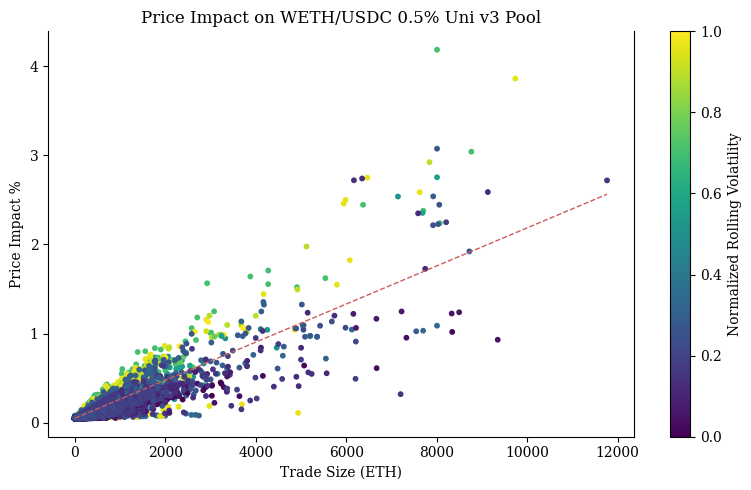

In [34]:
def plot_price_impact(df, name, cmap='viridis', fn=None):

    ols = gen_multi_var_reg(df, x_vars=["trade_size_x"], y_var=["price_impact"])

    f, ax = plt.subplots(figsize=(8,5))
    ax.scatter(df["trade_size_x"], df["price_impact"]*100, c=df["rolling_volatility"], s=10, cmap=cmap)
    f.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, label="Normalized Rolling Volatility")

    b, m = ols.params
    x = np.linspace(0, df['trade_size_x'].max())
    y = (m*x + b)*100
    ax.plot(x, y, c='indianred', linestyle='--', lw=1)

    ax.set_ylabel('Price Impact %')
    ax.set_xlabel('Trade Size (ETH)')
    ax.set_title(f'Price Impact on {name}')

    f.tight_layout()

    if fn:
        plt.savefig(fn, bbox_inches="tight", dpi=300)
        plt.close()

    return f

plot_price_impact(eth_usdc_0_05_df, 'WETH/USDC 0.5% Uni v3 Pool', fn = '../figs/manual/price_impact_weth_usdc_0_5.png')

Index(['amount0_adjusted', 'amount1_adjusted', 'price_implied', 'price_actual',
       'previous_price_actual', 'price_movement_percentage', 'evt_tx_hash',
       'evt_block_number', 'evt_block_time', 'evt_index', 'trade_size_x',
       'trade_size_y', 'price_impact', 'unix_timestamp', 'date_x', 'date_y',
       'volatility_std', 'unix_timestamp_first', 'unix_timestamp_last',
       'price_actual_mean', 'rolling_volatility', 'new_cross_impact'],
      dtype='object') (324223, 22)


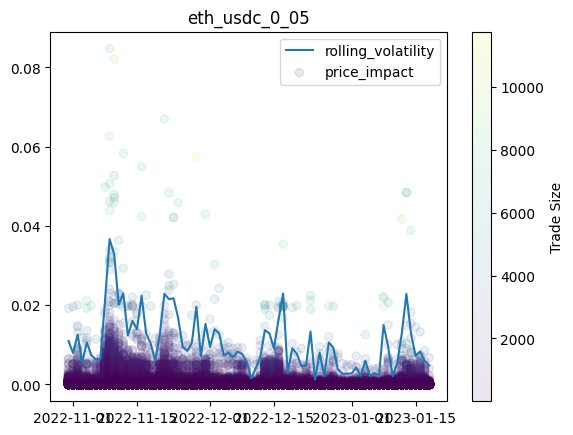

        price_impact  trade_size_x
0       2.135799e-04     44.795065
1       1.350877e-06      0.283250
2       6.199687e-05     13.000000
3       2.244637e-05      4.706741
4       5.525080e-07      0.115854
...              ...           ...
324218  3.890367e-04    217.433465
324219  4.796703e-04    161.912360
324220  1.629567e-05      5.500000
324221  5.102564e-06      1.722181
324222  9.421885e-07      0.318000

[324223 rows x 2 columns]


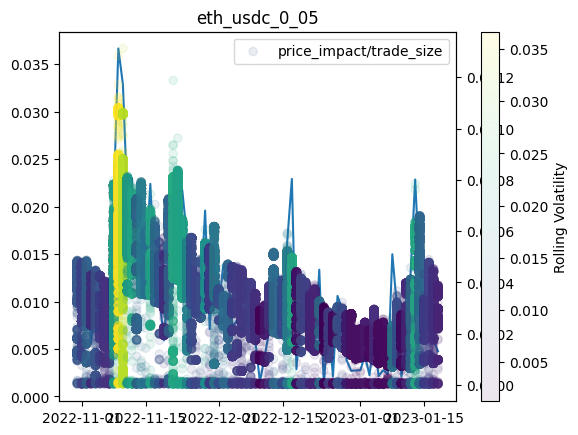

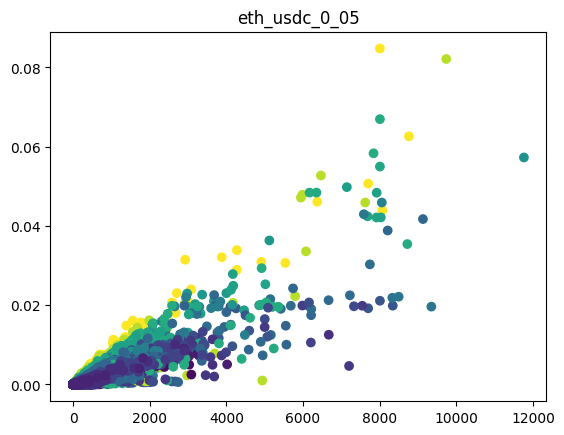

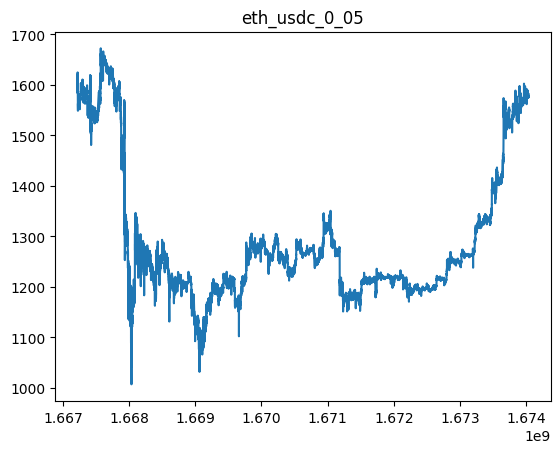

,amount0_adjusted,amount1_adjusted,price_implied,price_actual,previous_price_actual,price_movement_percentage,evt_tx_hash,evt_block_number,evt_block_time,evt_index,...,price_impact,unix_timestamp,date_x,date_y,volatility_std,unix_timestamp_first,unix_timestamp_last,price_actual_mean,rolling_volatility,new_cross_impact
0,-7.249315e-08,4.479507e+13,1618.329023,1618.965675,1619.311527,2.136255e-04,0xd3ecaedd9a03729eb01ecc534396dc26ec0b68095f04...,15868177.0,2022-10-31 12:55:35+00:00,252,...,2.135799e-04,1667220935,2022-10-31,2022-10-31,0.000574,1667220935,1667260787,1570.259913,0.010973,0.491529
1,-4.585392e-10,2.832496e+11,1618.852242,1619.660979,1619.663167,1.350879e-06,0x1c3862c56e26577c3b7b2a8056c90aef46b072fa93e9...,15868182.0,2022-10-31 12:56:35+00:00,32,...,1.350877e-06,1667220995,2022-10-31,2022-10-31,0.000574,1667220935,1667260787,1570.259913,0.010973,0.003108
2,-2.104441e-08,1.300000e+13,1618.800966,1619.560565,1619.660979,6.200071e-05,0xf8e26224471cdf131cdb7b7972cd62aa6073e2b34766...,15868182.0,2022-10-31 12:56:35+00:00,88,...,6.199687e-05,1667220995,2022-10-31,2022-10-31,0.000574,1667220935,1667260787,1570.259913,0.010973,0.142647
3,-7.618955e-09,4.706741e+12,1618.732617,1619.524212,1619.560565,2.244688e-05,0x26e6a85c07018cfae7c527048ce251fc0ddc1e560271...,15868184.0,2022-10-31 12:56:59+00:00,54,...,2.244637e-05,1667221019,2022-10-31,2022-10-31,0.000574,1667220935,1667260787,1570.259913,0.010973,0.051646
4,-1.875343e-10,1.158539e+11,1618.713999,1619.523317,1619.524212,5.525083e-07,0x032d844add0ab827e43bf3faebd03005c817246f2277...,15868184.0,2022-10-31 12:56:59+00:00,122,...,5.525080e-07,1667221019,2022-10-31,2022-10-31,0.000574,1667220935,1667260787,1570.259913,0.010973,0.001271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324218,-3.426315e-07,2.174335e+14,1575.799128,1576.198500,1576.811938,3.891881e-04,0x5ce94a98e3fa3c89599c91eacf24b9e0723e049c8e6f...,16432635.0,2023-01-18 08:56:47+00:00,2,...,3.890367e-04,1674032207,2023-01-18,2023-01-18,0.000249,1674000083,1674032291,1580.438318,0.004765,1.036171
324219,-2.550172e-07,1.619124e+14,1575.032517,1575.442444,1576.198500,4.799005e-04,0x017804cc2fb78cc470ce0baff87a573ecc615456ff25...,16432637.0,2023-01-18 08:57:11+00:00,2,...,4.796703e-04,1674032231,2023-01-18,2023-01-18,0.000249,1674000083,1674032291,1580.438318,0.004765,0.771587
324220,-8.660530e-09,5.500000e+12,1574.641893,1575.416771,1575.442444,1.629594e-05,0x127c7e706d1ae73a386a417c8bd05ff3b06cc60bf80a...,16432637.0,2023-01-18 08:57:11+00:00,308,...,1.629567e-05,1674032231,2023-01-18,2023-01-18,0.000249,1674000083,1674032291,1580.438318,0.004765,0.026210
324221,-2.711789e-09,1.722181e+12,1574.625045,1575.408733,1575.416771,5.102590e-06,0x17a53aadbebd9f469b7ca80e8b96f523255d45c5711e...,16432639.0,2023-01-18 08:57:35+00:00,48,...,5.102564e-06,1674032255,2023-01-18,2023-01-18,0.000249,1674000083,1674032291,1580.438318,0.004765,0.008207


In [13]:
plot_stats(merged_df=eth_usdc_0_05_df,name="eth_usdc_0_05",type="collateral")

In [10]:
ols1 = gen_multi_var_reg(eth_usdc_0_05_df,x_vars=["trade_size_x"],y_var=["price_impact"])
intercept = ols1.params[0]  # This is the intercept (often denoted as 'b0')
slopes = ols1.params[1:]    # These are the slopes (coefficients for the predictors, 'b1', 'b2', ...)
print("rsquared",ols1.rsquared)
print("rsquared_adj",ols1.rsquared_adj)
print("intercept",intercept)
print("slopes",slopes)

rsquared 0.8088130916456486
rsquared_adj 0.8088125019648187
intercept -1.2198137790222523e-05
slopes trade_size_x    0.000004
dtype: float64


/var/folders/3r/4cwkccx9163_2pw62tzw8jwh0000gn/T/ipykernel_87379/436092269.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = ols1.params[0]  # This is the intercept (often denoted as 'b0')


In [7]:
ols1 = gen_multi_var_reg(eth_usdc_0_05_df,x_vars=["new_cross_impact"],y_var=["price_impact"])
intercept = ols1.params[0]  # This is the intercept (often denoted as 'b0')
slopes = ols1.params[1:]    # These are the slopes (coefficients for the predictors, 'b1', 'b2', ...)
print("rsquared",ols1.rsquared)
print("rsquared_adj",ols1.rsquared_adj)
print("intercept",intercept)
print("slopes",slopes)

rsquared 0.8579650904929563
rsquared_adj 0.8579646524124201
intercept 1.7581702711667e-05
slopes new_cross_impact    0.000215
dtype: float64


/var/folders/3r/4cwkccx9163_2pw62tzw8jwh0000gn/T/ipykernel_87379/3581264146.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = ols1.params[0]  # This is the intercept (often denoted as 'b0')


In [6]:
ols1 = gen_multi_var_reg(eth_usdc_0_05_df,x_vars=["rolling_volatility","amount1_adjusted"],y_var=["price_impact"])
intercept = ols1.params[0]  # This is the intercept (often denoted as 'b0')
slopes = ols1.params[1:]    # These are the slopes (coefficients for the predictors, 'b1', 'b2', ...)
print("rsquared",ols1.rsquared)
print("rsquared_adj",ols1.rsquared_adj)
print("intercept",intercept)
print("slopes",slopes)

# p,cov = lin_reg(eth_usdc_0_05_df, x_var="amount1_adjusted", y_var="price_impact",name="Trade Size vs Price Impact",color_var="rolling_volatility")
# slope = p[0]
# intercept = p[1]
# errors = np.sqrt(np.diag(cov))
# y_fit = slope * eth_usdc_0_05_df["amount1_adjusted"] + intercept

# p,cov = lin_reg(eth_usdc_0_05_df, x_var="new_cross_impact", y_var="price_impact",name="Trade Size x Volatility vs Price Impact",color_var="unix_timestamp")
# slope = p[0]
# intercept = p[1]
# errors = np.sqrt(np.diag(cov))
# y_fit = slope * eth_usdc_0_05_df["new_cross_impact"] + intercept

rsquared 0.8088129098970237
rsquared_adj 0.8088123202156332
intercept -1.2191442204797172e-05
slopes rolling_volatility   -1.460323e-07
amount1_adjusted      4.258265e-18
dtype: float64


/var/folders/3r/4cwkccx9163_2pw62tzw8jwh0000gn/T/ipykernel_87379/3879418984.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = ols1.params[0]  # This is the intercept (often denoted as 'b0')


In [ ]:
ols2 = gen_multi_var_reg(eth_usdc_0_3_df,x_vars=["rolling_volatility","amount1_adjusted"],y_var=["price_impact"])
print(ols2)

In [ ]:
ols3 = gen_multi_var_reg(usdct_usdt_0_01_df,x_vars=["rolling_volatility","amount1_adjusted"],y_var=["price_impact"])
print(ols3)

In [ ]:
ols4 = gen_multi_var_reg(dai_usdc_0_01_df,x_vars=["rolling_volatility","amount1_adjusted"],y_var=["price_impact"])
print(ols4)

In [ ]:
lin_reg(eth_usdc_0_05_df, x_var="amount1_adjusted", y_var="price_impact",name=None,color_var="rolling_volatility")
lin_reg(eth_usdc_0_3_df, x_var="amount1_adjusted", y_var="price_impact",name=None,color_var="rolling_volatility")

lin_reg(usdct_usdt_0_01_df, x_var="amount1_adjusted", y_var="price_impact",name=None,color_var="rolling_volatility")
lin_reg(dai_usdc_0_01_df, x_var="amount1_adjusted", y_var="price_impact",name=None,color_var="rolling_volatility")

In [ ]:
lin_reg(eth_usdc_0_3_df, x_var="amount1_adjusted", y_var="new_cross_impact",name=None,color_var="rolling_volatility")
lin_reg(usdct_usdt_0_01_df, x_var="amount1_adjusted", y_var="new_cross_impact",name=None,color_var="rolling_volatility")
lin_reg(dai_usdc_0_01_df, x_var="amount1_adjusted", y_var="new_cross_impact",name=None,color_var="rolling_volatility")

In [ ]:
# plot_3d_relationships(eth_usdc_0_05_df)
plot_3d_relationships(eth_usdc_0_3_df)
plot_3d_relationships(usdct_usdt_0_01_df)
# plot_3d_relationships(dai_usdc_0_01_df)

In [ ]:
import plotly.express as px
import numpy as np
# new slippage function based on empirical analysis
def quad_output(x):
    """
    @notice calculate price impact when selling x or y to the open market.
    Assuming that we trade against Uniswap is a conservative assumption
    """
    a,b,c = (2.602424822058012e-10,2.3009044333523045e-07,0.0004613261845851614)
    return(a*x**2+b*x+c)

x = np.logspace(-9,5, num=50, endpoint=True, base=10.0, dtype=None, axis=0)
y = [quad_output(x) for x in x]
fig=px.line(x=x, y=y)
fig.show()

def lin_output(x):
    return 1.081593506690093e-06*x+0.0004379110082802476

x = np.logspace(-9,5, num=50, endpoint=True, base=10.0, dtype=None, axis=0)
print(x)
y = [lin_output(x) for x in x]
fig=px.line(x=x, y=y)
fig.show()